In [51]:
import os
import yaml
import numpy as np

import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import seaborn as sns

import ml_collections
from clu import checkpoint


from molnet import utils, train_state, train
from molnet.data import input_pipeline_seg
from molnet.models import create_model
from configs import root_dirs
from analyses import make_predictions

from typing import Tuple

INDEX_TO_SYMBOL = {
    0: 'background',
    1: 'H',
    2: '(He)',
    3: '(Li)',
    4: '(Be)',
    5: '(B)',
    6: 'C',
    7: 'N',
    8: 'O',
    9: 'F'
}

In [2]:
#workdir = "/u/79/kurkil1/unix/work/molnet/runs/bf16-augs-rebias-adam-3e-4-z10-reverse-z/"
#workdir = "/u/79/kurkil1/unix/work/molnet/runs/bf16-augs-rebias-adam-3e-4-z20-interp/"
workdir = "/u/79/kurkil1/unix/work/molnet/runs/segmentation/seg-augs-rebias-adam-3e-4"

In [3]:
def load_from_workdir(
    workdir: str,
    return_attention: bool
):
    # Load the model config
    with open(os.path.join(workdir, "config.yaml"), "rt") as f:
        config = yaml.unsafe_load(f)
    config = ml_collections.ConfigDict(config)
    config.root_dir = root_dirs.get_root_dir("afms_rebias")
    config.model.return_attention_maps = return_attention

    print(config)

    # Create the model
    model = create_model(config.model)

    checkpoint_dir = os.path.join(workdir, "checkpoints")
    ckpt = checkpoint.Checkpoint(checkpoint_dir)

    apply_fn = model.apply
    tx = utils.create_optimizer(config)
    restored_state = ckpt.restore(state=None)['state']

    # Load the model state
    state = train_state.EvaluationState.create(
        apply_fn=apply_fn,
        params=restored_state['params'],
        batch_stats=restored_state['batch_stats'],
        tx=tx,
    )
    state = jax.tree_util.tree_map(jnp.asarray, state)

    return state, config

In [4]:
state, config = load_from_workdir(
    workdir=workdir,
    return_attention=False
)

batch_size: 12
cutout_probs:
- 0.5
- 0.3
- 0.1
- 0.05
- 0.05
dataset: afms_rebias
debug: false
eval_every_steps: 2000
gaussian_factor: 1.0
interpolate_input_z: null
learning_rate: 0.0003
learning_rate_schedule: constant
learning_rate_schedule_kwargs:
  decay_steps: 50000
  init_value: 0.0003
  peak_value: 0.0006
  warmup_steps: 2000
log_every_steps: 100
loss_fn: cross_entropy
max_atoms: 54
max_shift_per_slice: 0.02
model:
  attention_activation: sigmoid
  attention_channels:
  - 16
  - 32
  - 64
  - 64
  - 128
  conv_activation: relu
  decoder_channels:
  - 256
  - 128
  - 64
  - 32
  - 16
  decoder_kernel_size:
  - - 3
    - 3
    - 3
  - - 3
    - 3
    - 3
  - - 3
    - 3
    - 3
  - - 3
    - 3
    - 3
  - - 3
    - 3
    - 3
  dtype: bfloat16
  encoder_channels:
  - 16
  - 32
  - 64
  - 128
  - 256
  encoder_kernel_size:
  - - 3
    - 3
    - 3
  - - 3
    - 3
    - 3
  - - 3
    - 3
    - 3
  - - 3
    - 3
    - 3
  - - 3
    - 3
    - 3
  model_name: Attention-UNet
  output_acti

2025-02-25 13:54:52.361484: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1960] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [5]:
rng = jax.random.PRNGKey(0)
datarng, rng = jax.random.split(rng)
#with config.unlocked():
    #config.z_cutoff = 1.0
    #config.interpolate_z = None
    #config.target_z_cutoff = 1.0
    #config.train_molecules = (0, 80000)
    #config.val_molecules = (80000, 100000)
    #config.max_shift_per_slice = 0.02

ds = input_pipeline_seg.get_datasets(
    config
)['val']

batch = next(ds)

for k, v in batch.items():
    print(k, v.shape)

[libprotobuf ERROR external/com_google_protobuf/src/google/protobuf/text_format.cc:337] Error parsing text-format tensorflow.data.experimental.DistributedSnapshotMetadata: 1:1: Invalid control characters encountered in text.
[libprotobuf ERROR external/com_google_protobuf/src/google/protobuf/text_format.cc:337] Error parsing text-format tensorflow.data.experimental.DistributedSnapshotMetadata: 1:3: Expected identifier, got: 18085879115725111131


images (12, 128, 128, 10, 1)
xyz (12, 54, 5)
sw (12, 2, 3)
atom_map (12, 128, 128, 10)


[libprotobuf ERROR external/com_google_protobuf/src/google/protobuf/text_format.cc:337] Error parsing text-format tensorflow.data.experimental.DistributedSnapshotMetadata: 1:1: Invalid control characters encountered in text.
[libprotobuf ERROR external/com_google_protobuf/src/google/protobuf/text_format.cc:337] Error parsing text-format tensorflow.data.experimental.DistributedSnapshotMetadata: 1:3: Expected identifier, got: 17927960504738319970
[libprotobuf ERROR external/com_google_protobuf/src/google/protobuf/text_format.cc:337] Error parsing text-format tensorflow.data.experimental.DistributedSnapshotMetadata: 1:1: Invalid control characters encountered in text.
[libprotobuf ERROR external/com_google_protobuf/src/google/protobuf/text_format.cc:337] Error parsing text-format tensorflow.data.experimental.DistributedSnapshotMetadata: 1:3: Expected identifier, got: 1363218185392474230
[libprotobuf ERROR external/com_google_protobuf/src/google/protobuf/text_format.cc:337] Error parsing t

In [6]:
@jax.jit
def predict(
    state,
    batch,
):
    inputs, targets = batch['images'], batch['atom_map']
    preds = state.apply_fn(
        {'params': state.params, 'batch_stats': state.batch_stats},
        inputs,
        training=False,
    )
    return inputs, targets, preds, batch["xyz"]

In [7]:
batch = next(ds)

In [8]:
inputs, targets, preds, xyz = predict(state, batch)

In [9]:
print(targets.shape, preds.shape)

(12, 128, 128, 10) (12, 128, 128, 10, 10)


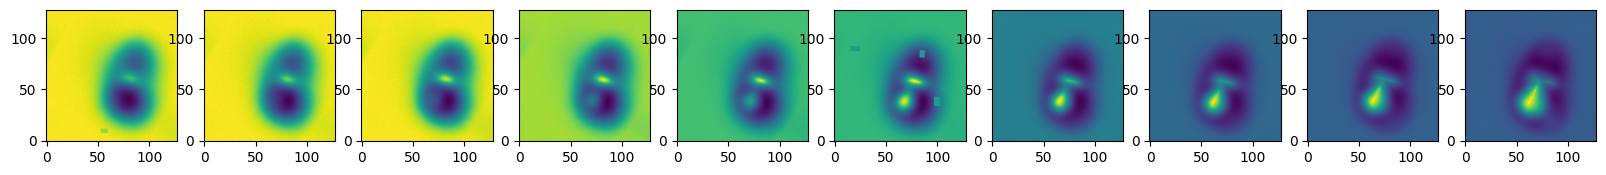

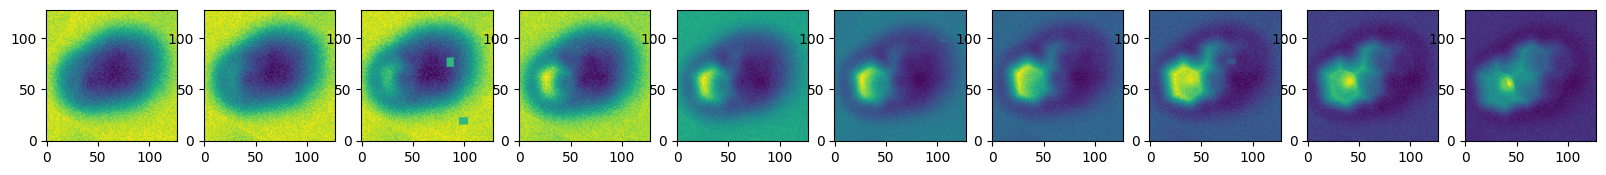

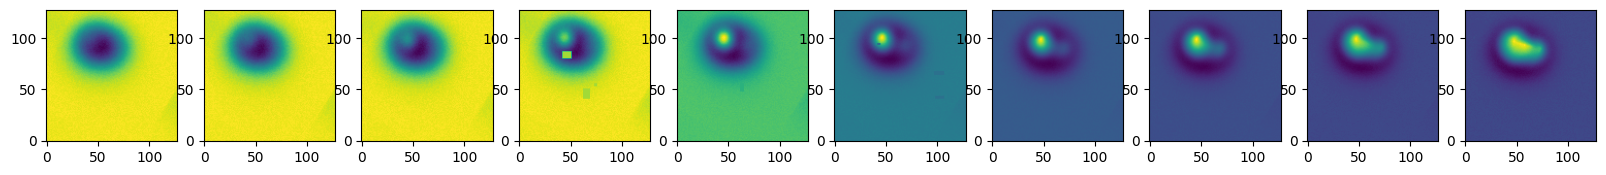

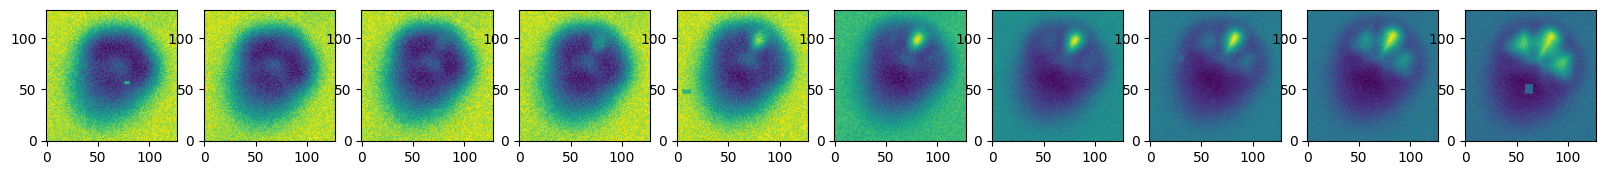

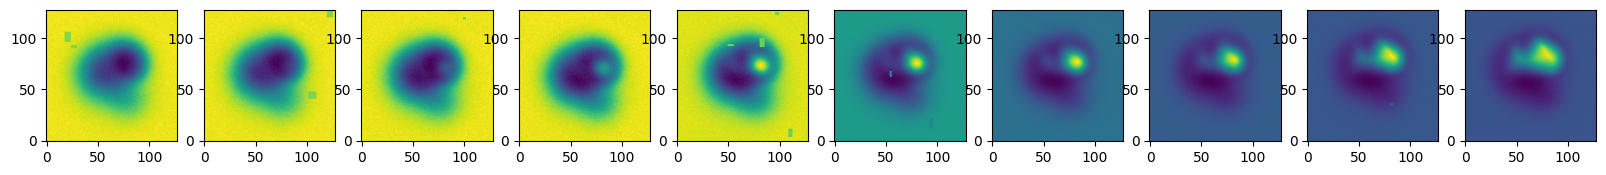

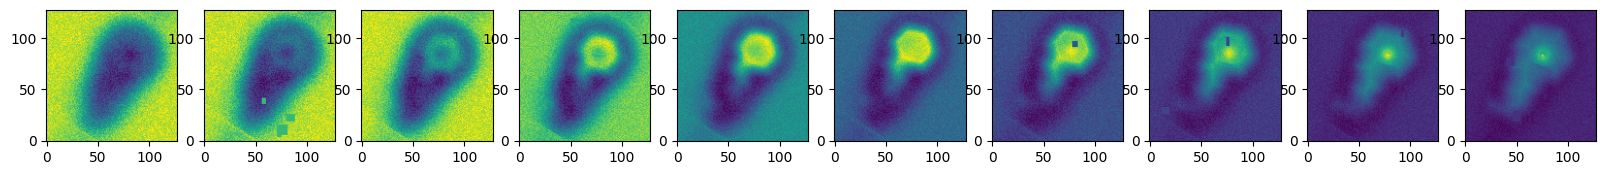

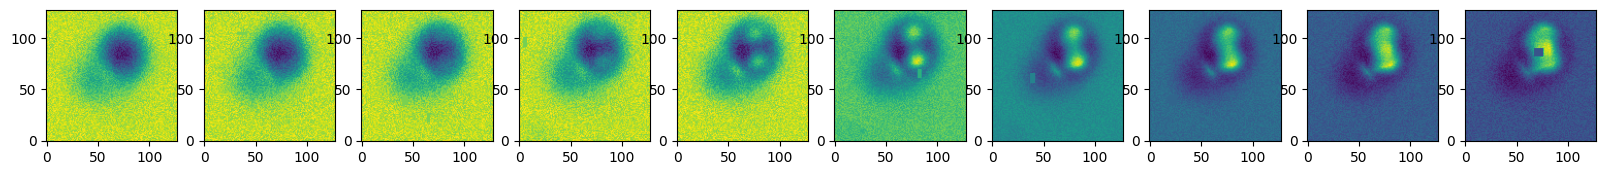

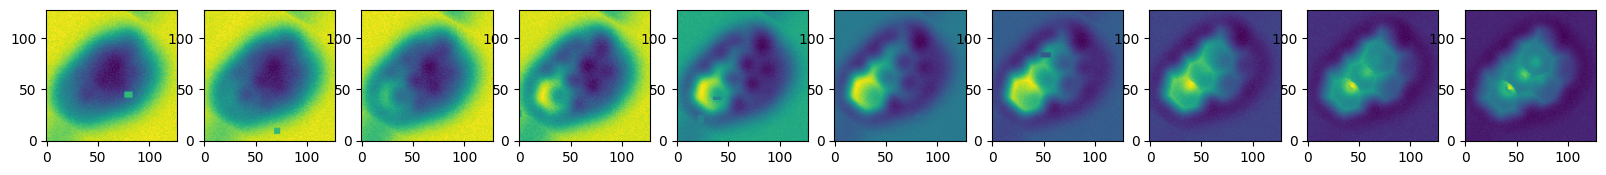

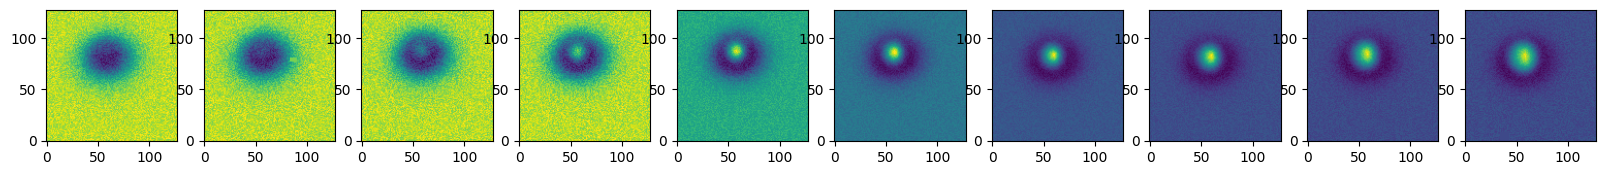

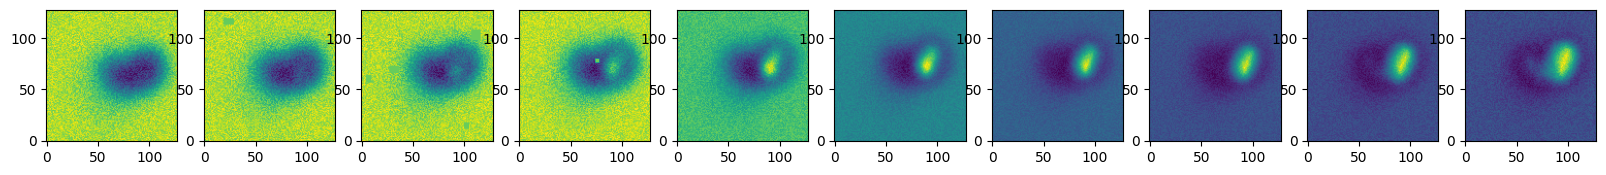

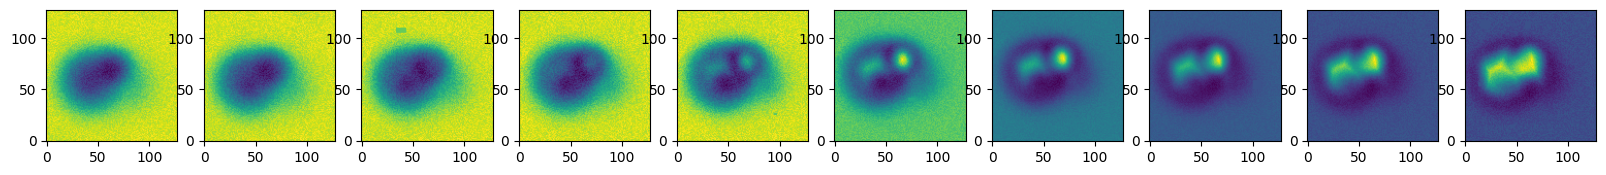

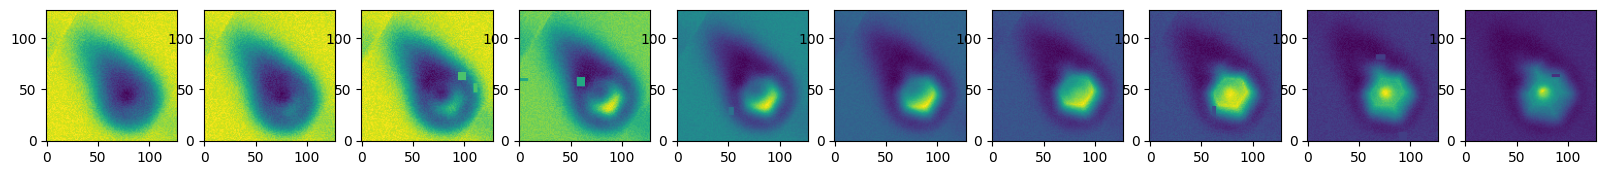

In [10]:
for i in range(inputs.shape[0]):
    fig = plt.figure(figsize=(20, 2))
    for z in range(preds.shape[-2]):
        ax = plt.subplot(1, 10, z+1)
        ax.imshow(inputs[i, ..., z, 0], origin='lower')

    plt.show()

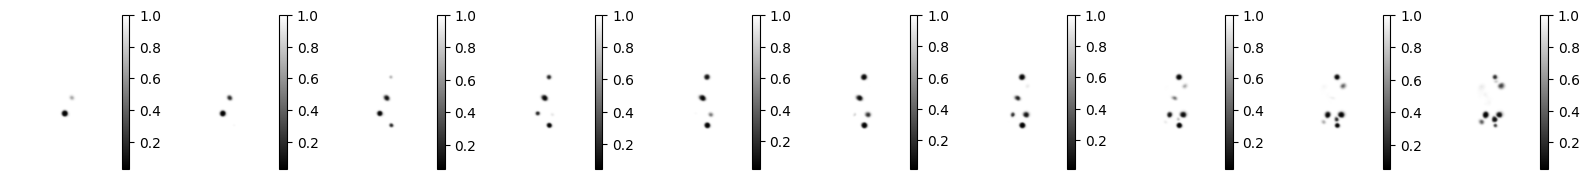

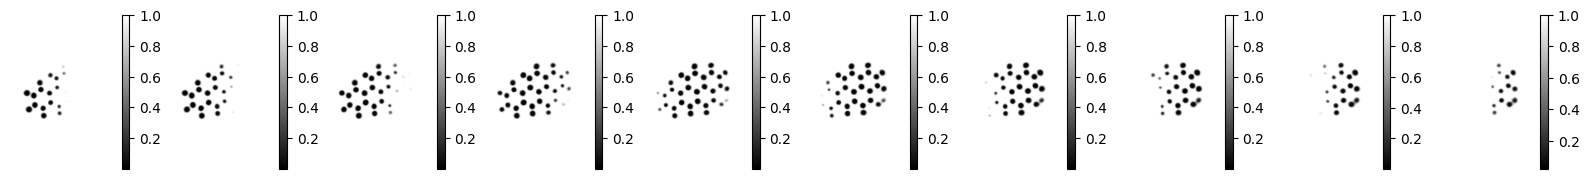

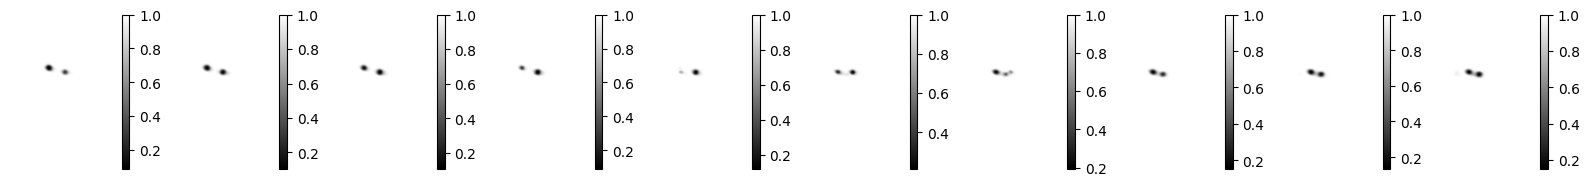

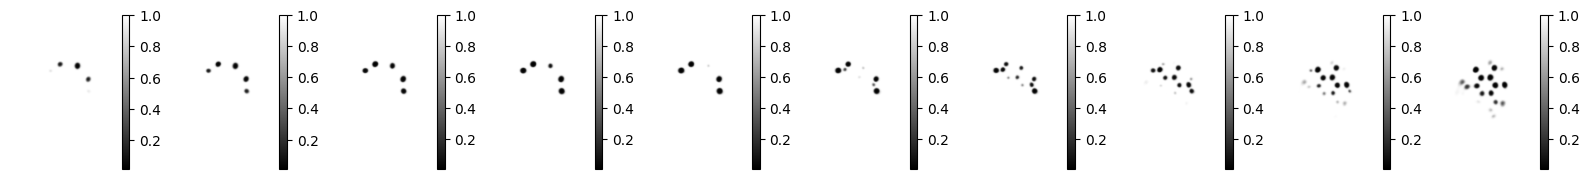

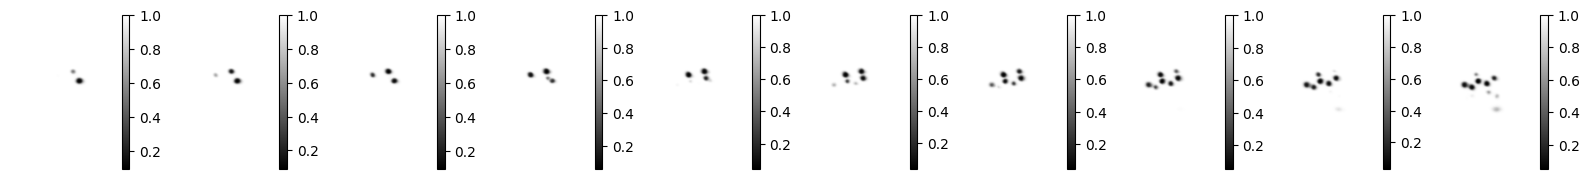

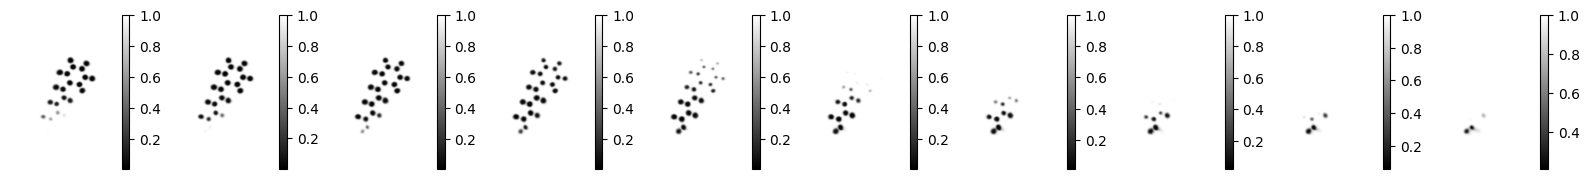

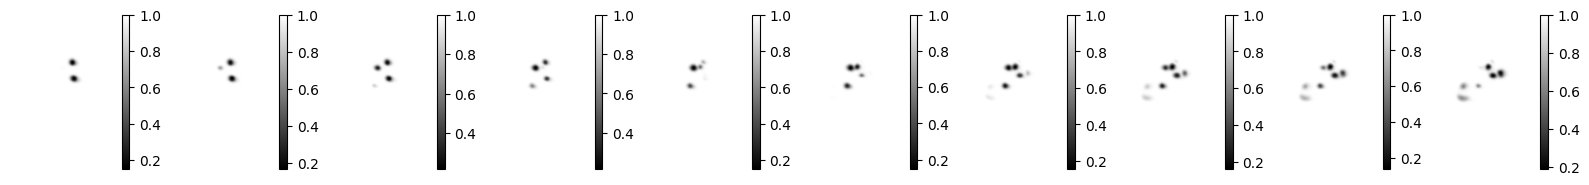

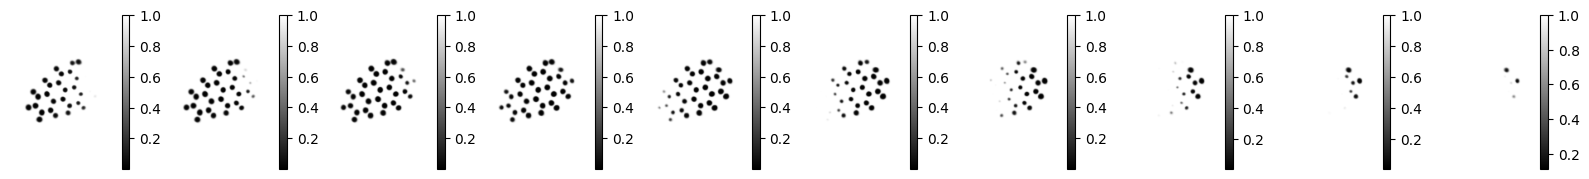

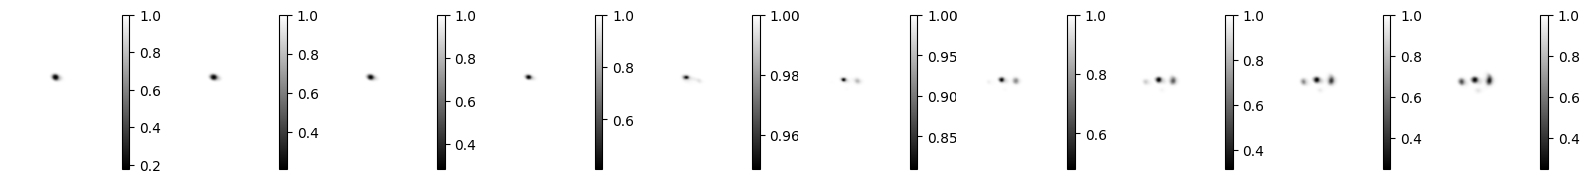

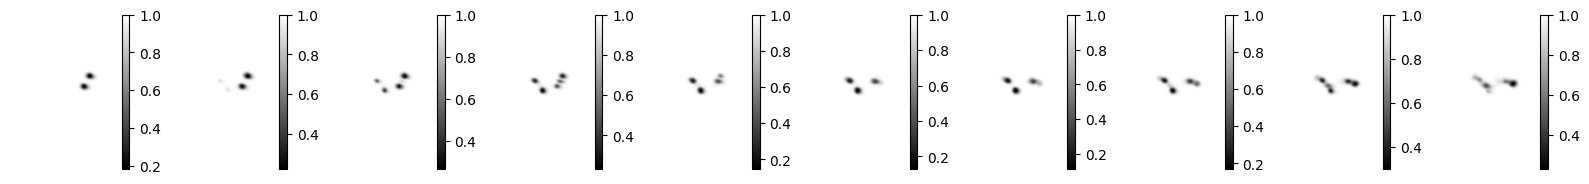

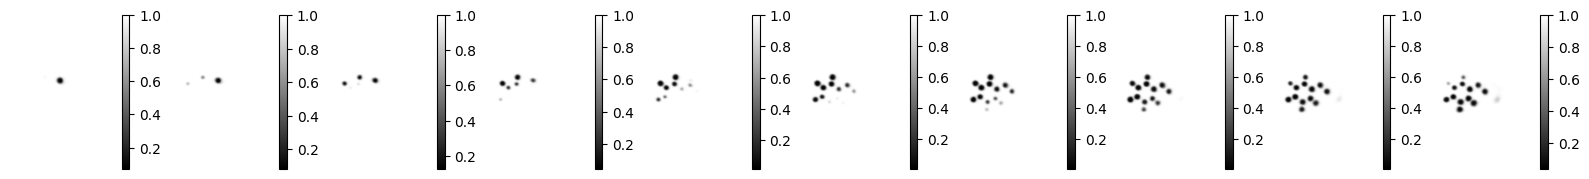

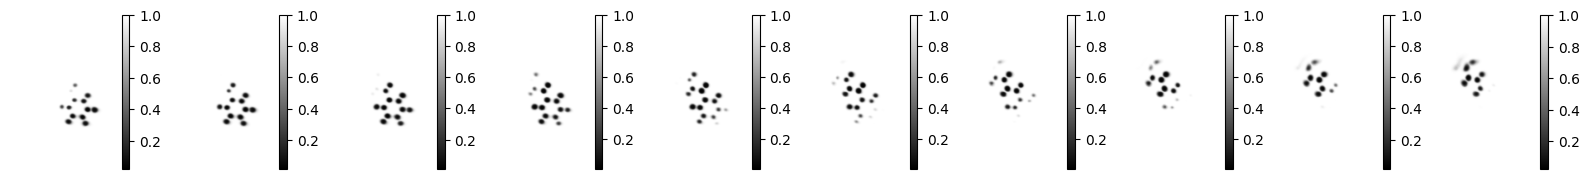

In [ ]:
for i in range(inputs.shape[0]):
    fig = plt.figure(figsize=(20, 2))
    pred_softmax = jax.nn.softmax(preds[i], axis=-1)
    for z in range(preds.shape[-2]):
        ax = plt.subplot(1, 10, z+1)
        im = ax.imshow(pred_softmax[..., z, 0], cmap="gray", origin='lower')
        plt.colorbar(im)
        ax.set_axis_off()


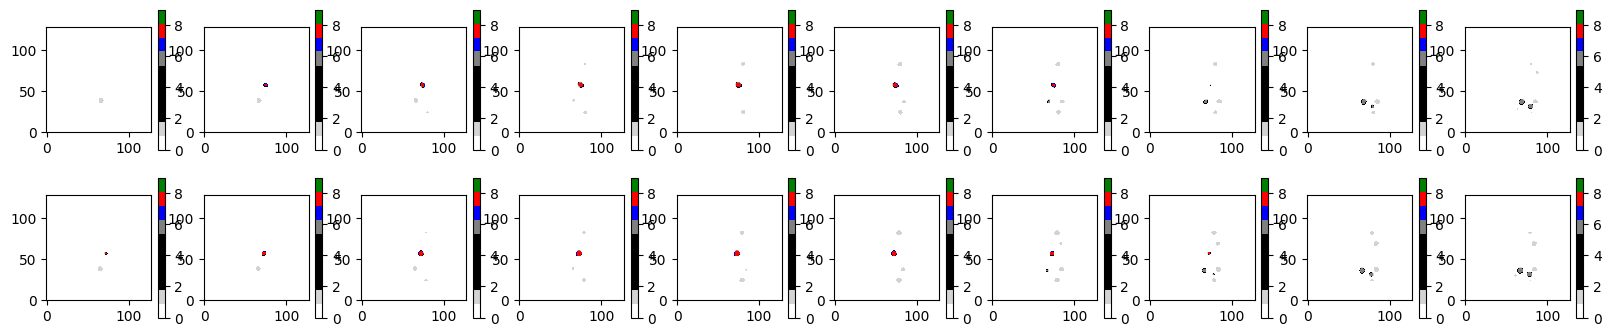

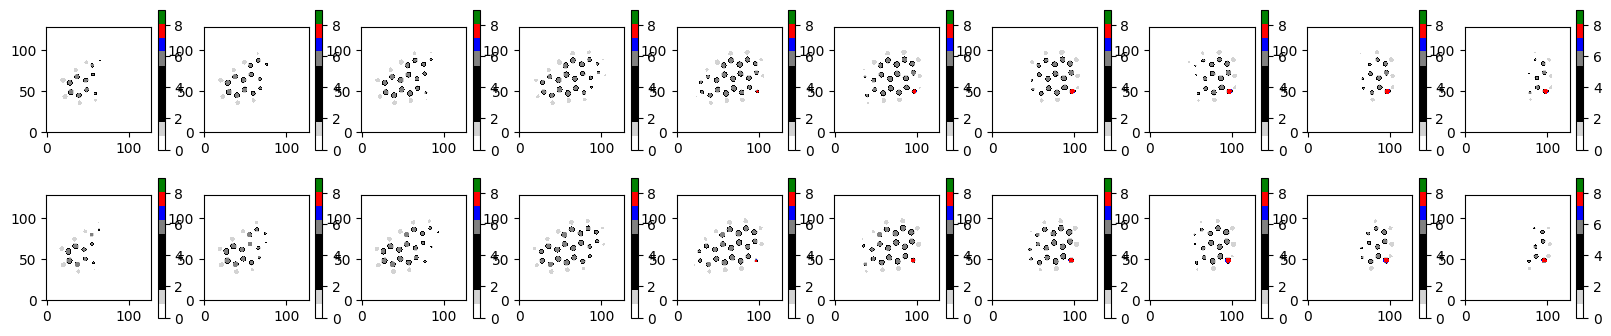

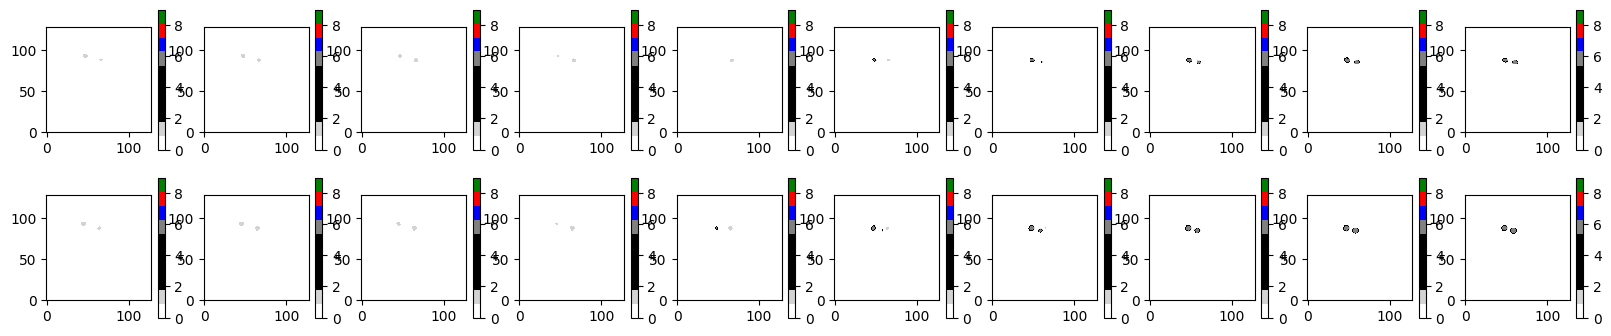

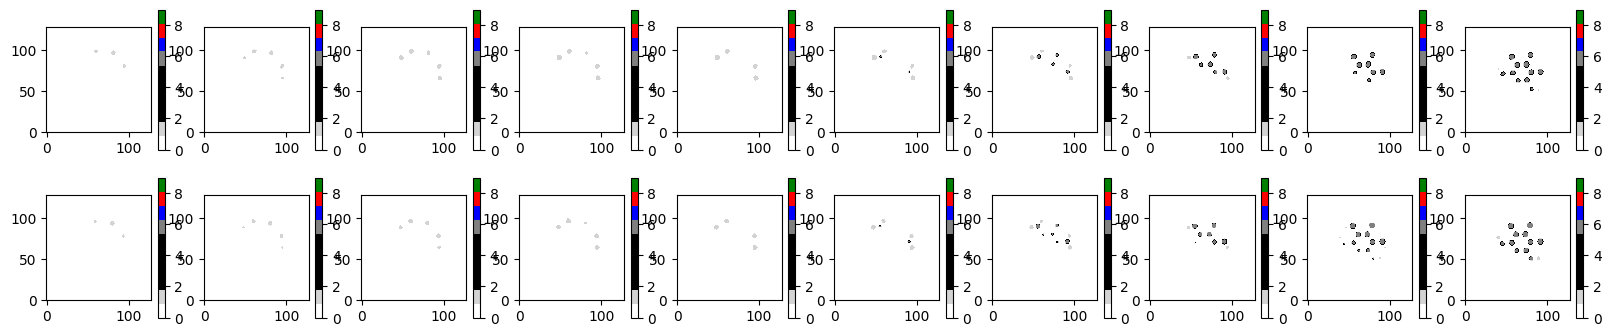

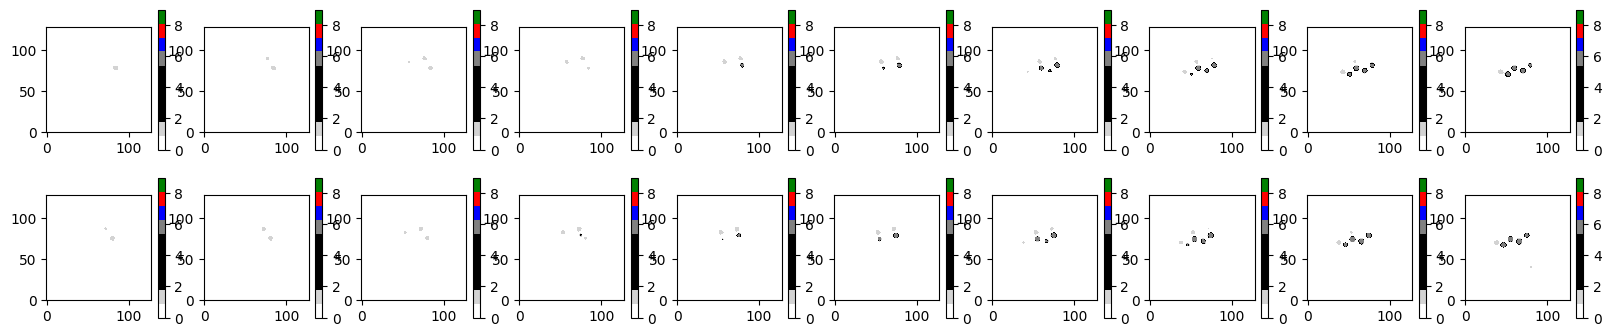

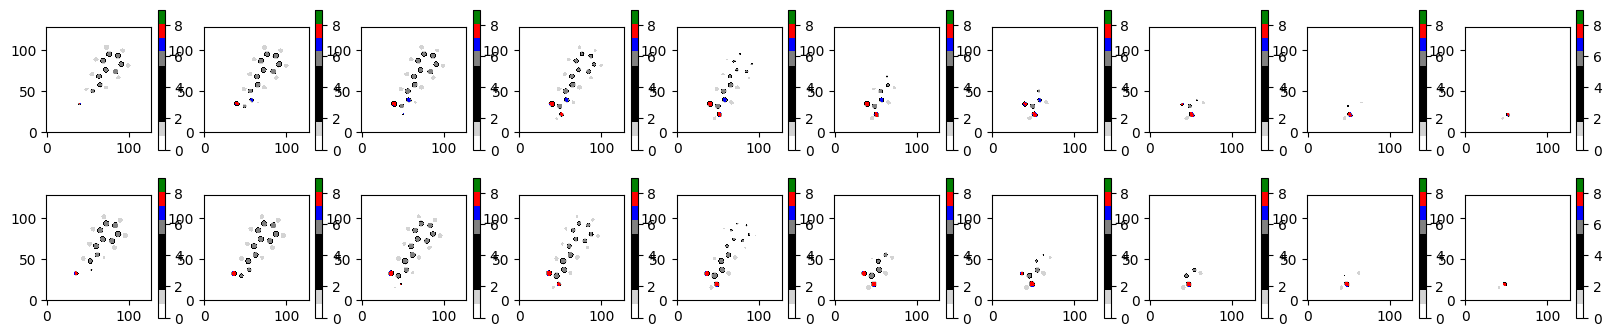

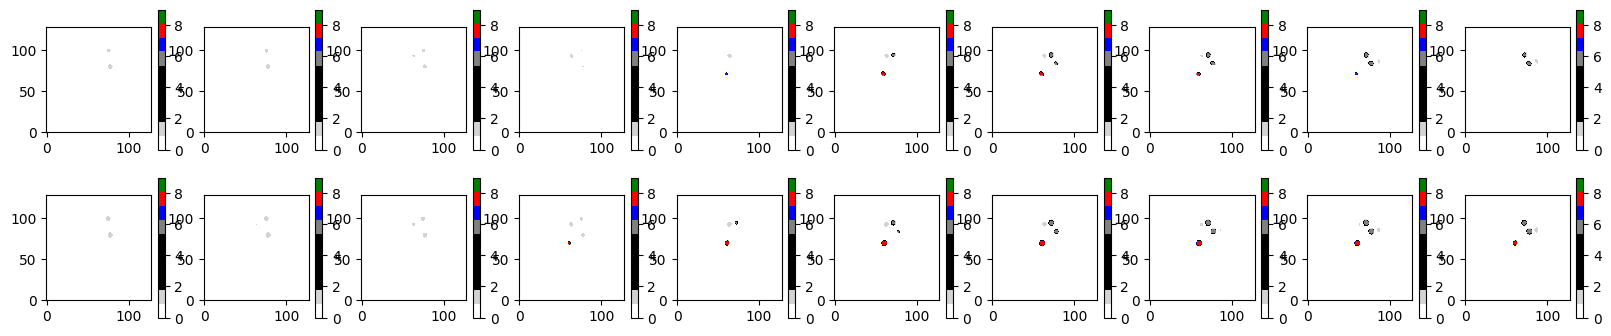

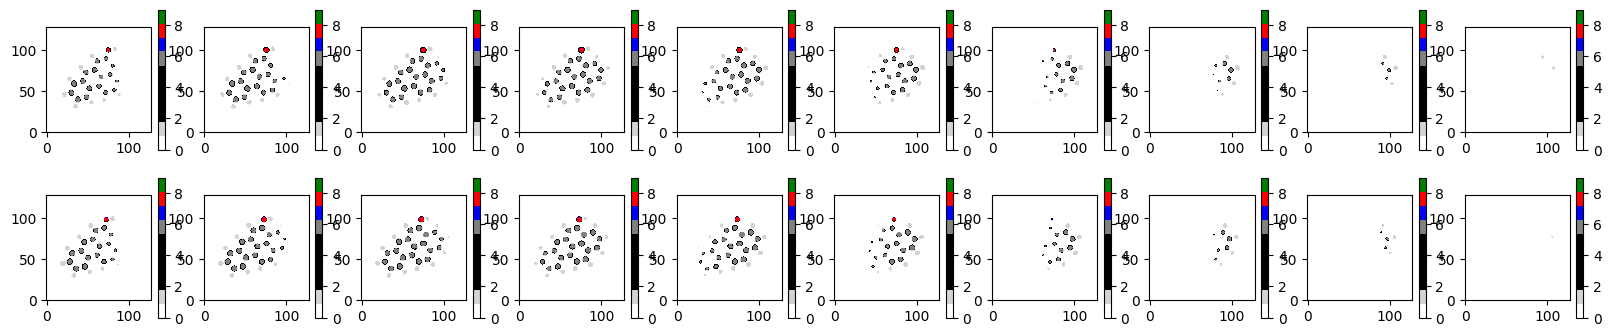

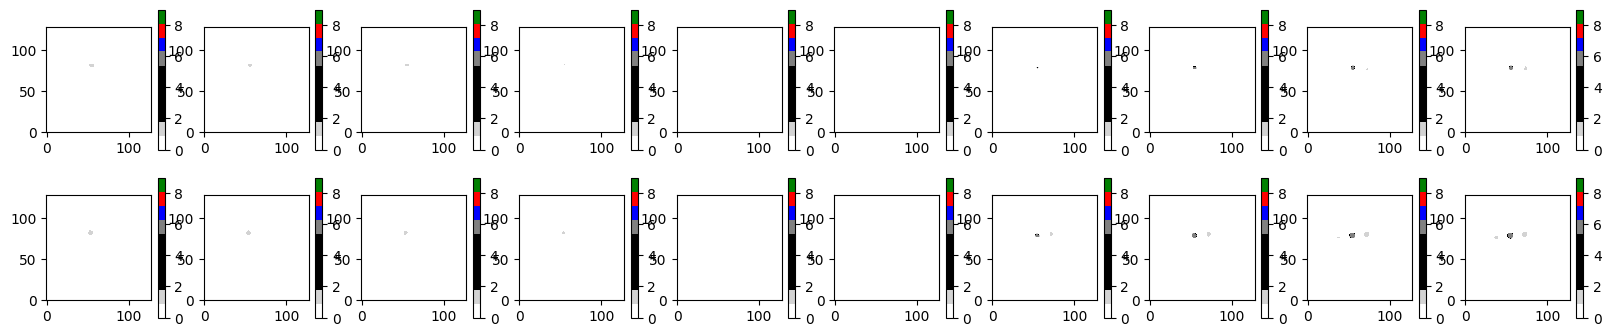

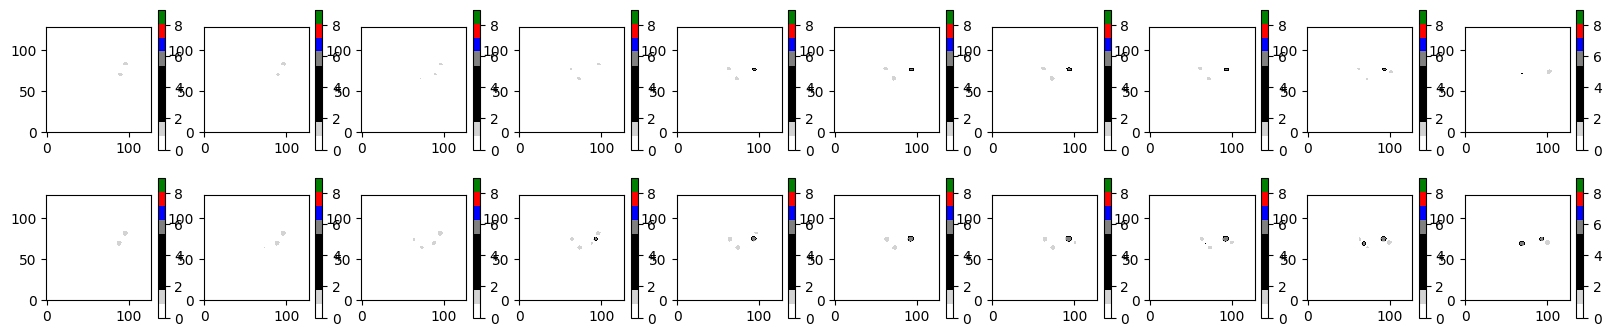

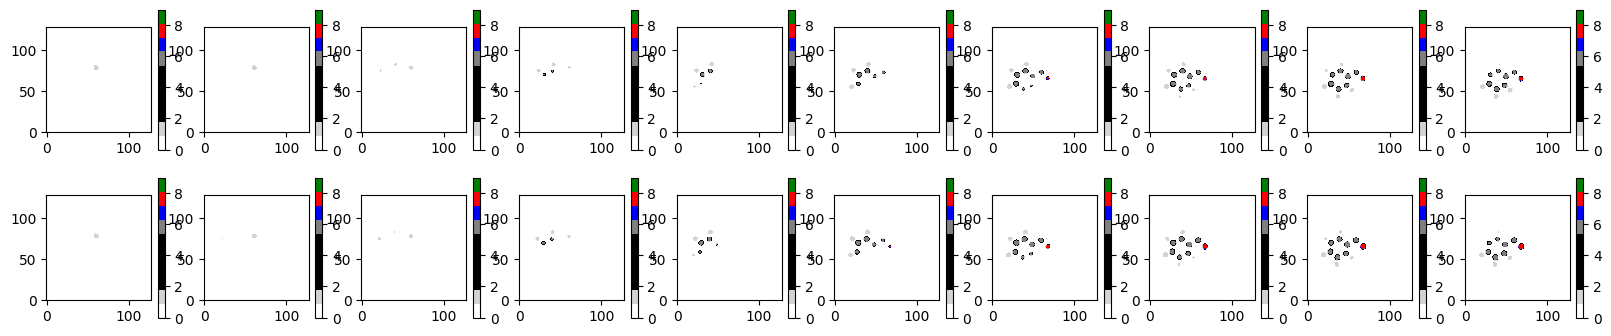

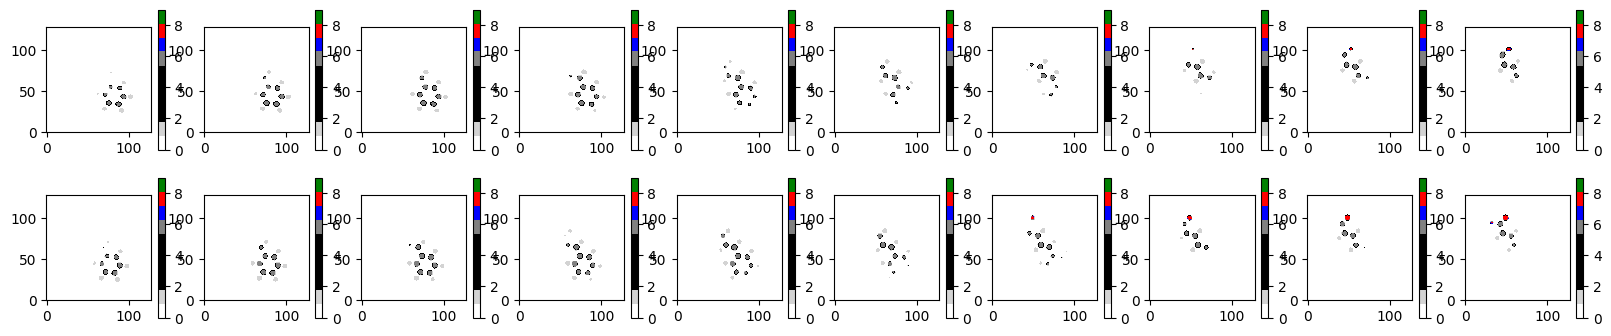

In [24]:
# Create a custom colormap, with white for the background
from matplotlib.colors import ListedColormap

my_cmap = ListedColormap(['white', 'lightgray', 'k', 'k', 'k', 'k', "gray", 'blue', "red", 'green'])

for i in range(inputs.shape[0]):
    fig = plt.figure(figsize=(20, 4))
    pred_argmax = jnp.argmax(preds[i], axis=-1)
    for z in range(preds.shape[-2]):
        ax = plt.subplot(2, 10, z+1)
        im = ax.imshow(pred_argmax[..., z], cmap=my_cmap, origin='lower', vmin=0, vmax=9)
        plt.colorbar(im)

        ax = plt.subplot(2, 10, z+11)
        im = ax.imshow(targets[i, ..., z], cmap=my_cmap, origin='lower', vmin=0, vmax=9)
        plt.colorbar(im)
        

In [25]:
# Compute the dice score
def dice_score(
    pred: jnp.ndarray,
    target: jnp.ndarray,
    epsilon: float = 1e-8
) -> jnp.ndarray:
    intersection = jnp.sum(pred * target)
    union = jnp.sum(pred) + jnp.sum(target)
    return (2 * intersection + epsilon) / (union + epsilon)

dice_scores = []

for i in range(100):
    batch = next(ds)
    inputs, targets, preds, xyz = predict(state, batch)
    pred_argmax = jnp.argmax(preds, axis=-1)
    dice = dice_score(pred_argmax, targets)
    dice_scores.append(dice)

print(jnp.mean(jnp.array(dice_scores)))

2.7704957


In [27]:
# Compute accuracy per class, i.e. argmax == target for each class in the target
def class_accuracy(
    pred: jnp.ndarray,
    target: jnp.ndarray
) -> jnp.ndarray:
    acc = []
    for i in range(1, 10):
        pred_class = pred == i
        target_class = target == i
        acc.append(jnp.mean(jnp.array(pred_class == target_class)))
    return jnp.array(acc)

class_accuracies = []

for i in range(100):
    batch = next(ds)
    inputs, targets, preds, xyz = predict(state, batch)
    pred_argmax = jnp.argmax(preds, axis=-1)
    class_acc = class_accuracy(pred_argmax, targets)
    class_accuracies.append(class_acc)

print(jnp.mean(jnp.array(class_accuracies), axis=0))

[0.9959091  1.         1.         1.         1.         0.9963702
 0.9994174  0.999307   0.99995863]


In [55]:
# Compute and plot confusion matrix
def confusion_matrix(
    pred: jnp.ndarray,
    target: jnp.ndarray
) -> jnp.ndarray:
    conf_matrix = np.zeros((10, 10))
    for i in range(0, 10):
        for j in range(0, 10):
            pred_class = pred == i
            target_class = target == j
            conf_matrix[i, j] = jnp.sum(pred_class * target_class)
    return conf_matrix

conf_matrices = []

for i in range(100):
    batch = next(ds)
    inputs, targets, preds, xyz = predict(state, batch)
    pred_argmax = jnp.argmax(preds, axis=-1)
    conf_matrix = confusion_matrix(pred_argmax, targets)
    conf_matrices.append(conf_matrix)

Text(120.72222222222221, 0.5, 'True')

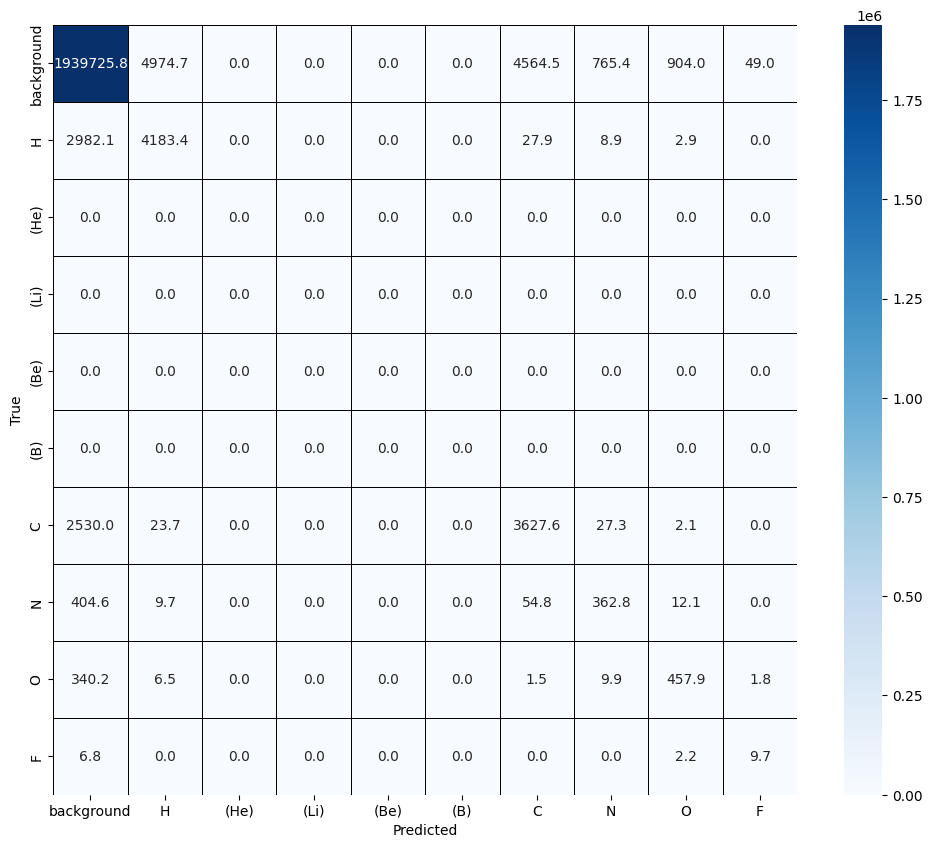

In [57]:
conf_matrix = jnp.mean(jnp.array(conf_matrices), axis=0)

fig = plt.figure(figsize=(12, 10))
sns.heatmap(
    conf_matrix,
    annot=True, fmt=".1f", cmap="Blues",
    linewidths=0.5, linecolor="black",
    xticklabels=[INDEX_TO_SYMBOL[i] for i in range(0, 10)],
    yticklabels=[INDEX_TO_SYMBOL[i] for i in range(0, 10)]
)
plt.xlabel("Predicted")
plt.ylabel("True")